In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda, Normalize, Compose
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import torch.optim as optim
import os
import random
from torch.autograd import Variable
from torchvision.utils import make_grid
from tqdm.auto import tqdm

In [ ]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [ ]:
# Тренировочный датасет
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Тестовый датасет
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


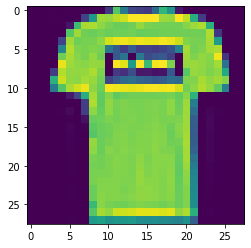

In [ ]:
plt.imshow(np.array(training_data.data[1]))

In [ ]:
class VAE(nn.Module):
    def __init__(self, imgChannels=1, featureDim=32*20*20, zDim=256):
        super(VAE, self).__init__()

        # 2 сверточных слоя и 2 полносвязных слоя для енкодера 
        self.encConv1 = nn.Conv2d(imgChannels, 16, 5)
        self.encConv2 = nn.Conv2d(16, 32, 5)
        self.encFC1 = nn.Linear(featureDim, zDim)
        self.encFC2 = nn.Linear(featureDim, zDim)

        # полносвязный слой и 2 сверточных для декодера
        self.decFC1 = nn.Linear(zDim, featureDim)
        self.decConv1 = nn.ConvTranspose2d(32, 16, 5)
        self.decConv2 = nn.ConvTranspose2d(16, imgChannels, 5)

    def encoder(self, x):

        # Mu (среднее) и logVar (вариация) используются для генерации z 
        x = F.relu(self.encConv1(x))
        x = F.relu(self.encConv2(x))
        x = x.view(-1, 32*20*20)
        mu = self.encFC1(x)
        logVar = self.encFC2(x)
        return mu, logVar

    def reparameterize(self, mu, logVar):

        #семплируем mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decoder(self, z):

        # размеры входной и выходной картинок одинаковые
        x = F.relu(self.decFC1(z))
        x = x.view(-1, 32, 20, 20)
        x = F.relu(self.decConv1(x))
        x = torch.sigmoid(self.decConv2(x))
        return x

    def forward(self, x):

        # VAE: encoder -> reparameterization -> decoder
        # output, mu, и logVar для loss computation 
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        out = self.decoder(z)
        return out, mu, logVar
 

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
batch_size = 128
learning_rate = 1e-3
num_epochs = 10


train_loader = torch.utils.data.DataLoader(
    training_data, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_data,batch_size=1)


net = VAE().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)


for epoch in range(num_epochs):
    for idx, data in enumerate(train_loader, 0):
        imgs, _ = data
        imgs = imgs.to(device)

        # подаем бач картинок в сеть чтобы посмотреть результат (output image, mu, и logVar)
        out, mu, logVar = net(imgs)

        # BCE loss + KL divergence 
        kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(out, imgs, size_average=False) + kl_divergence

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch {}: Loss {}'.format(epoch, loss))


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0: Loss 25677.515625
Epoch 1: Loss 23369.13671875
Epoch 2: Loss 24807.013671875
Epoch 3: Loss 23952.033203125
Epoch 4: Loss 23126.75
Epoch 5: Loss 24359.25
Epoch 6: Loss 23962.890625
Epoch 7: Loss 25159.837890625
Epoch 8: Loss 22599.314453125
Epoch 9: Loss 23475.63671875


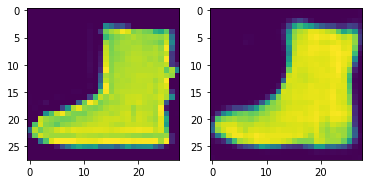

In [ ]:
net.eval()
with torch.no_grad():
    for data in random.sample(list(test_loader), 1):
        imgs, _ = data
        imgs = imgs.to(device)
        img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        plt.subplot(121)
        plt.imshow(np.squeeze(img))
        out, mu, logVAR = net(imgs)
        outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        plt.subplot(122)
        plt.imshow(np.squeeze(outimg))
        break


## **GAN**

In [ ]:
mnist = FashionMNIST(root='data', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

In [ ]:
mnist

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [ ]:
# Смотрим на данные

img, label = mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  9
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])


(tensor(-1.), tensor(1.))

In [ ]:
# для просмотра изображений 
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [ ]:
img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

NameError: ignored

In [ ]:
# DataLoader чтобы данные загружались батчами во время обучения

batch_size = 128
#dataloader 
train_dl = DataLoader(mnist, batch_size, shuffle=True)

first batch
torch.Size([128, 1, 28, 28])
tensor([5, 7, 4, 7, 3, 8, 9, 5, 3, 1, 2, 3, 2, 3, 3, 7, 9, 9, 3, 2, 4, 6, 3, 5,
        5, 3, 2, 0, 0, 8, 4, 2, 8, 5, 9, 2, 4, 9, 4, 4, 3, 4, 9, 7, 2, 0, 4, 5,
        4, 8, 2, 6, 7, 0, 2, 0, 6, 3, 3, 5, 6, 0, 0, 8, 7, 5, 1, 3, 5, 1, 0, 8,
        6, 6, 6, 7, 5, 3, 2, 1, 8, 1, 6, 3, 4, 3, 6, 3, 4, 6, 9, 9, 1, 2, 2, 0,
        3, 8, 7, 9, 4, 5, 6, 7, 8, 7, 6, 6, 9, 3, 9, 8, 9, 2, 4, 7, 5, 3, 2, 0,
        2, 4, 6, 9, 9, 1, 5, 9])


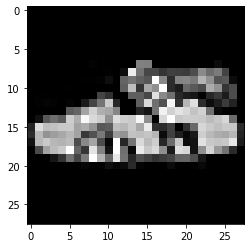

In [ ]:
 # распечатаем изображения в батче
 
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [ ]:
def random_noise_generator(batch_size, dim):
    return torch.rand(batch_size, dim)*2 - 1

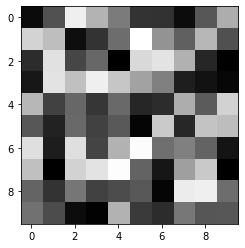

In [ ]:
#Just checking the noise generator and plotting one of its outputs
a = random_noise_generator(64, 100)
b = a[2]
b = b.reshape(10, 10)
b = b.numpy()
plt.imshow(b, cmap = 'gray')

In [ ]:
import torch.nn as nn

image_size = 784
hidden_size = 256

#Дискриминатор :

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [ ]:
latent_size = 64

#Генератор :

G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [ ]:
y = gen(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

RuntimeError: ignored

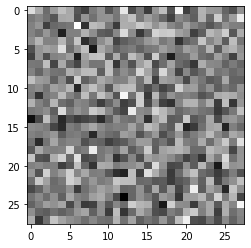

In [ ]:
plt.imshow(gen_imgs[0], cmap='gray');

In [ ]:
D.to(device);
G.to(device);

In [ ]:
#Тренируем дискриминатор :

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Лейблы которые пойдут на вход BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    # Loss для настоящих изображений
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss для фальшивых (сгенерированных) изображений
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs
    
    # Отправляем настоящие изображения в дискриминатор и обучаем его понимать паттерны реальных картинок.
    # Затем генерируем фейковые изображения и отправляем дискриминатору обучаться понимать паттерны сгенерированных картинок.

    # суммируем ошибки
    d_loss = d_loss_real + d_loss_fake
    # обнуляем градиент
    reset_grad()
    # считаем
    d_loss.backward()
    # оптимизируем параметры с помощью backprop
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

In [ ]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [ ]:
def train_generator():
    # Генерируем  изображения и считаем loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop и оптимизация 
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

In [ ]:
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

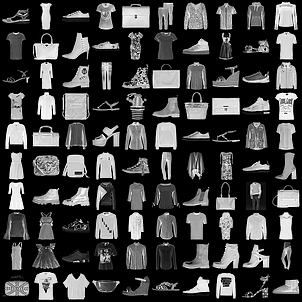

In [ ]:
from IPython.display import Image
from torchvision.utils import save_image

# Настоящие изображения
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


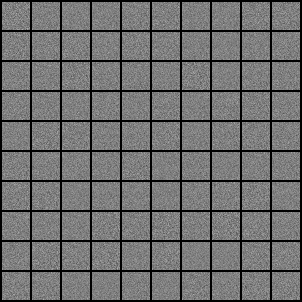

In [ ]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# До обучения у нас только шум
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [ ]:
%%time

num_epochs = 200
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # представляем в виде вектора
        images = images.reshape(batch_size, -1).to(device)
        
        # тренируем дискриминатор и генератор
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
    
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # семплируем и сохраняем изображения
    save_fake_images(epoch+1)

Epoch [0/200], Step [200/600], d_loss: 0.2765, g_loss: 3.7712, D(x): 0.90, D(G(z)): 0.14
Epoch [0/200], Step [400/600], d_loss: 0.0630, g_loss: 4.7367, D(x): 0.97, D(G(z)): 0.03
Epoch [0/200], Step [600/600], d_loss: 0.0392, g_loss: 5.5430, D(x): 0.98, D(G(z)): 0.01
Saving fake_images-0001.png
Epoch [1/200], Step [200/600], d_loss: 0.0501, g_loss: 4.0791, D(x): 0.98, D(G(z)): 0.03
Epoch [1/200], Step [400/600], d_loss: 0.0794, g_loss: 4.4021, D(x): 0.98, D(G(z)): 0.03
Epoch [1/200], Step [600/600], d_loss: 0.0074, g_loss: 5.5727, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0002.png
Epoch [2/200], Step [200/600], d_loss: 0.0633, g_loss: 5.7381, D(x): 0.99, D(G(z)): 0.03
Epoch [2/200], Step [400/600], d_loss: 0.0143, g_loss: 9.2023, D(x): 0.99, D(G(z)): 0.01
Epoch [2/200], Step [600/600], d_loss: 0.0179, g_loss: 6.0133, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0003.png
Epoch [3/200], Step [200/600], d_loss: 0.0184, g_loss: 6.2574, D(x): 1.00, D(G(z)): 0.02
Epoch [3/200], Step [400/6

In [ ]:
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

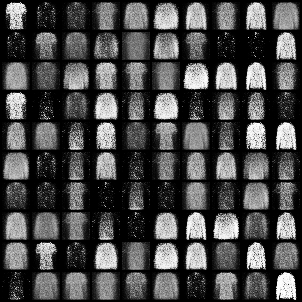

In [ ]:
Image('./samples/fake_images-0010.png')

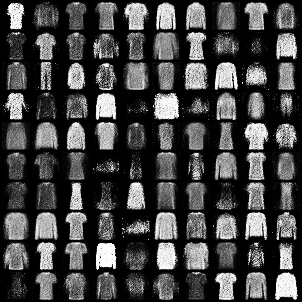

In [ ]:
Image('./samples/fake_images-0050.png')

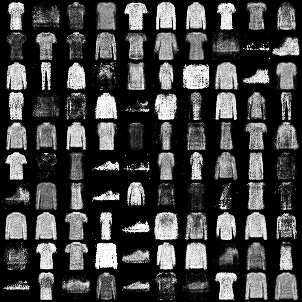

In [ ]:
Image('./samples/fake_images-0150.png')

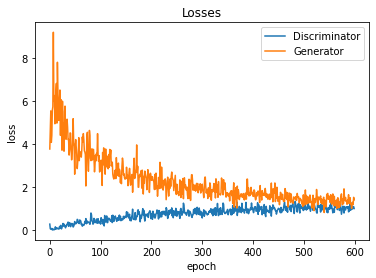

In [ ]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

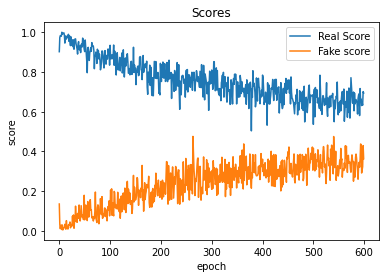

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');